In [1]:
"""
This plots the performance of CLIPNET on specific annotation sets
(e.g. promoters, enhancers, housekeeping promoters, etc.) 
We use averaged profiles across all 67 libraries as ground truth.
"""

'\nThis plots the performance of CLIPNET on specific annotation sets\n(e.g. promoters, enhancers, housekeeping promoters, etc.) \nWe use averaged profiles across all 67 libraries as ground truth.\n'

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import warnings
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.linear_model import LinearRegression
import pyranges

from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density # needed for density scatter plots
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# COLORS:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#440053"),
    (0.2, "#404388"),
    (0.4, "#2a788e"),
    (0.6, "#21a784"),
    (0.8, "#78d151"),
    (1, "#fde624"),
], N=256)
# "Viridis-like" colormap with white background
white_viridis_r = LinearSegmentedColormap.from_list("white_viridis", [
    (0, "#ffffff"),
    (1e-20, "#fde624"),
    (0.4, "#78d151"),
    (0.6, "#21a784"),
    (0.7, "#2a788e"),
    (0.8, "#404388"),
    (1, "#440053"),
], N=256)
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

URL = "https://zenodo.org/records/13771189/files"
TAR = "evaluation_metric.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -xvzf {SCRATCH}/{TAR}")

# Download cCRE data from ENCODE:
print(f"wget https://downloads.wenglab.org/cCREs/GRCh38-PLS.bed -P {SCRATCH}")
print(f"wget https://downloads.wenglab.org/cCREs/GRCh38-ELS.bed -P {SCRATCH}")

wget https://zenodo.org/records/13771189/files/evaluation_metric.tar.gz -P /Users/adamhe/github/scratch
tar -xvzf /Users/adamhe/github/scratch/evaluation_metric.tar.gz
wget https://downloads.wenglab.org/cCREs/GRCh38-PLS.bed -P /Users/adamhe/github/scratch
wget https://downloads.wenglab.org/cCREs/GRCh38-ELS.bed -P /Users/adamhe/github/scratch


In [4]:
# LOAD TEST WINDOWS

# Load windows in from procap file (preserves ordering)
test_windows_ = pd.read_csv(os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), header=None).iloc[:, 0]

# Parse to pyranges-compatible dataframe
test_windows = pd.DataFrame(
    {
        "Chromosome": test_windows_.str.split(":", expand=True).iloc[:, 0],
        "Start": test_windows_.str.split(":", expand=True).iloc[:, 1].str.split("-", expand=True).iloc[:, 0].astype(int),
        "End": test_windows_.str.split(":", expand=True).iloc[:, 1].str.split("-", expand=True).iloc[:, 1].astype(int),
    }
)
# Add index so we can select by it later.
test_windows.reset_index(inplace=True)

In [5]:
# LOAD ANNOTATION DATA

# Load promoters and enhancers
prom_bed = pyranges.read_bed(os.path.join(SCRATCH, "GRCh38-PLS.bed"))
enh_bed = pyranges.read_bed(os.path.join(SCRATCH, "GRCh38-ELS.bed"))

# Filter for windows that overlap promoters and enhancers
prom_windows = pyranges.PyRanges(test_windows).overlap(prom_bed)
enh_windows = pyranges.PyRanges(test_windows).overlap(prom_bed, invert=True)

# Load housekeeping genes. This list was derived from the HRT Atlas database (https://doi.org/10.1093/nar/gkaa609)
# The ensembl IDs for housekeeping human genes (https://housekeeping.unicamp.br/Housekeeping_GenesHuman.csv)
# were used to download the TSS positions from Ensembl BioMart (https://www.ensembl.org/biomart/martview).
housekeeping_ = pd.read_csv("Housekeeping_GenesHuman_TSS.txt", sep="\t")
housekeeping = pd.DataFrame(
    {
        "Chromosome": "chr" + housekeeping_["Chromosome/scaffold name"].astype(str),
        "Start": housekeeping_["Transcription start site (TSS)"],
        "End": housekeeping_["Transcription start site (TSS)"] + 1,
    }
)

# Filter for windows that overlap housekeeping genes
housekeeping_windows = pyranges.PyRanges(test_windows).overlap(pyranges.PyRanges(housekeeping))

In [6]:
# LOAD PREDICTIONS, METRICS, AND LABELS

# Negative and positive bounds for model performance on correlation
mean_predictor_corr = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/mean_predictor_corrs.csv.gz"), index_col=0,
)
replicate_corr = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/replicate_pearsons.csv.gz"), index_col=0,
)

# Load profile pearsons
clipnet_pearson = h5py.File(
    os.path.join(SCRATCH, "evaluation_metric/merged_performance_0.h5")
)["track_pearson"][:]
puffin = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/puffin_clipnet_test_profile_corr.csv.gz"), index_col=0
)

# Load model predictions
clipnet = h5py.File(
    os.path.join(SCRATCH, "evaluation_metric/merged_prediction_0.h5")
)

# Load quantity predictions
merged_quantity = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, np.r_[250:750, 1250:1750]].sum(axis=1)

log_quantity = pd.DataFrame(
    {
        "clipnet": np.log10(clipnet["quantity"][:, 0]),
        "expt": np.log10(merged_quantity),
    }
)

# Load TSS predictions
clipnet_tss_pl = clipnet["track"][:, :500].argmax(axis=1)
clipnet_tss_mn = clipnet["track"][:, 500:].argmax(axis=1)
merged_tss_pl = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, 250:750].argmax(axis=1)
merged_tss_mn = pd.read_csv(
    os.path.join(SCRATCH, "evaluation_metric/merged_procap_0.csv.gz"), index_col=0, header=None
).to_numpy()[:, 1250:1750].argmax(axis=1)

tss = pd.DataFrame(
    {
        "clipnet": np.concatenate([clipnet_tss_pl, clipnet_tss_mn]),
        "expt": np.concatenate([merged_tss_pl, merged_tss_mn]),
    }
)

In [7]:
# Define subset of windows to plot

#subset = list(set(housekeeping_windows.index).union(set(enh_windows.index)))
subset = housekeeping_windows.index

dists = {
    "mean_predictor_corr": mean_predictor_corr.to_numpy()[subset],
    "replicate_corr": replicate_corr.mean(axis=1).to_numpy()[subset],
    "clipnet_pearson": clipnet_pearson[subset],
    "puffin": puffin.to_numpy()[subset],
}
log_quantity_ = log_quantity.iloc[subset, :]
tss_ = tss.iloc[subset, :]

In [8]:
# Define subset of windows to plot
hk = log_quantity.iloc[housekeeping_windows.index, :]
#hk["annotation"] = ["housekeeping_promoter"] * hk.shape[0]
enh = log_quantity.iloc[enh_windows.index, :]
#enh["annotation"] = ["enhancer"] * enh.shape[0]
prom = log_quantity.iloc[prom_windows.index, :]
#prom["annotation"] = ["promoter"] * prom.shape[0]

0.10484556769102549 0.53900736408321 0.7879749571691075 0.897964631148561


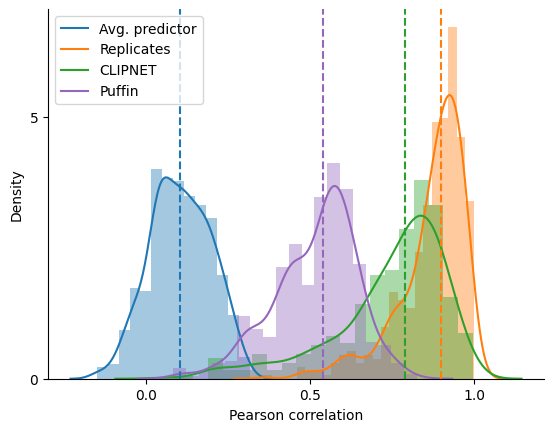

In [22]:
# Plot pdf of predicted vs observed pearson correlations

fig, d = plt.subplots()
sns.distplot(dists["mean_predictor_corr"], color=colors[0])
sns.distplot(dists["replicate_corr"], color=colors[1])
sns.distplot(dists["clipnet_pearson"], color=colors[2])
sns.distplot(dists["puffin"], color=colors[4])
plt.axvline(np.nanmedian(dists["mean_predictor_corr"]), 0, 1, color=colors[0], linestyle="--")
plt.axvline(np.nanmedian(dists["replicate_corr"]), 0, 1, color=colors[1], linestyle="--")
plt.axvline(np.nanmedian(dists["clipnet_pearson"]), 0, 1, color=colors[2], linestyle="--")
plt.axvline(np.nanmedian(dists["puffin"]), 0, 1, color=colors[4], linestyle="--")
d.set_yticks([0, 5])
#d.set_yticklabels(["", ""])
d.set_xticks([0, 0.5, 1])
#d.set_xticklabels(["", "", ""])
d.set_ylabel("Density")
d.set_xlabel("Pearson correlation")
plt.legend(["Avg. predictor", "Replicates", "CLIPNET", "Puffin"])
sns.despine()
#plt.savefig("img/pearson_kde.pdf")

print(
    np.nanmedian(dists["mean_predictor_corr"]),
    np.nanmedian(dists["puffin"]),
    np.nanmedian(dists["clipnet_pearson"]),
    np.nanmedian(dists["replicate_corr"]),
)

In [9]:
print(pearsonr(log_quantity.expt, log_quantity.clipnet))
print(spearmanr(log_quantity.expt, log_quantity.clipnet))
lr = LinearRegression(fit_intercept=True).fit(
        log_quantity.expt.to_numpy().reshape(-1, 1),
        log_quantity.clipnet.to_numpy().reshape(-1, 1),
    )
print(lr.coef_, lr.intercept_)

PearsonRResult(statistic=0.7339278710104438, pvalue=0.0)
SignificanceResult(statistic=0.7354219554215649, pvalue=0.0)
[[0.34114822]] [0.86903806]


In [11]:
print(pearsonr(enh.expt, enh.clipnet))
print(spearmanr(enh.expt, enh.clipnet))
lr = LinearRegression(fit_intercept=True).fit(
        enh.expt.to_numpy().reshape(-1, 1),
        enh.clipnet.to_numpy().reshape(-1, 1),
    )
print(lr.coef_, lr.intercept_)

PearsonRResult(statistic=0.6135837631390013, pvalue=1.769923657875257e-175)
SignificanceResult(statistic=0.5832221949731434, pvalue=1.1072849175976575e-154)
[[0.27009654]] [0.8884123]


In [12]:
print(pearsonr(prom.expt, prom.clipnet))
print(spearmanr(prom.expt, prom.clipnet))
lr = LinearRegression(fit_intercept=True).fit(
        prom.expt.to_numpy().reshape(-1, 1),
        prom.clipnet.to_numpy().reshape(-1, 1),
    )
print(lr.coef_, lr.intercept_)

PearsonRResult(statistic=0.6646703779059334, pvalue=0.0)
SignificanceResult(statistic=0.6548926602520059, pvalue=0.0)
[[0.29981878]] [0.95579082]


In [13]:
print(pearsonr(hk.expt, hk.clipnet))
print(spearmanr(hk.expt, hk.clipnet))
lr = LinearRegression(fit_intercept=True).fit(
        hk.expt.to_numpy().reshape(-1, 1),
        hk.clipnet.to_numpy().reshape(-1, 1),
    )
print(lr.coef_, lr.intercept_)

PearsonRResult(statistic=0.7055530723979717, pvalue=6.622847148639299e-79)
SignificanceResult(statistic=0.644343905512154, pvalue=7.258373760177084e-62)
[[0.30771264]] [0.98181304]


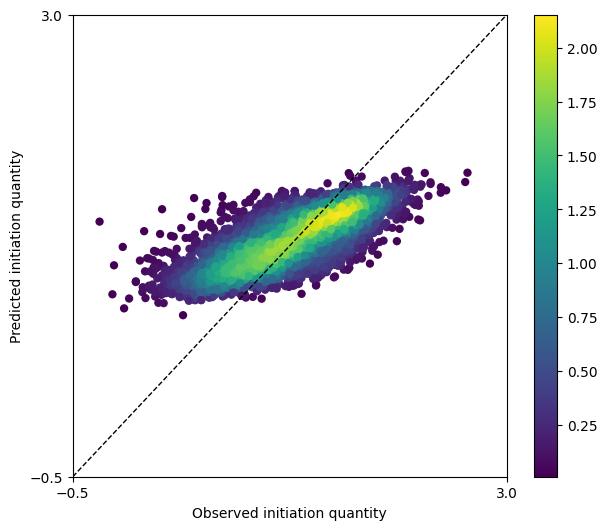

In [36]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
ax = sns.scatterplot(
    data=log_quantity,
    x="expt",
    y="clipnet",
    c=gaussian_kde(log_quantity.transpose())(log_quantity.transpose()),
    cmap="viridis",
    alpha=1,
    linewidth=0,
)
fig.colorbar(ax.collections[0], ax=ax, orientation="vertical")
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)
ax.set_xticks([-0.5, 3])
#ax.set_xticklabels(["", ""])
ax.set_yticks([-0.5, 3])
#ax.set_yticklabels(["", ""])
ax.set_ylabel("Predicted initiation quantity")
ax.set_xlabel("Observed initiation quantity")
ax.plot([-0.5, 3], [-0.5, 3], color="black", linestyle="--", linewidth=1)
plt.savefig("img/log_quantity_uncorr.pdf")

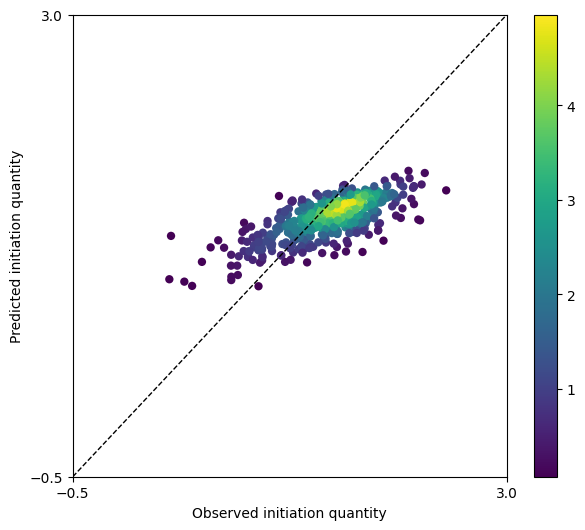

In [35]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
ax = sns.scatterplot(
    data=hk,
    x="expt",
    y="clipnet",
    c=gaussian_kde(hk.transpose())(hk.transpose()),
    cmap="viridis",
    alpha=1,
    linewidth=0,
)
fig.colorbar(ax.collections[0], ax=ax, orientation="vertical")
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)
ax.set_xticks([-0.5, 3])
#ax.set_xticklabels(["", ""])
ax.set_yticks([-0.5, 3])
#ax.set_yticklabels(["", ""])
ax.set_ylabel("Predicted initiation quantity")
ax.set_xlabel("Observed initiation quantity")
ax.plot([-0.5, 3], [-0.5, 3], color="black", linestyle="--", linewidth=1)
plt.savefig("img/log_quantity_hk.pdf")

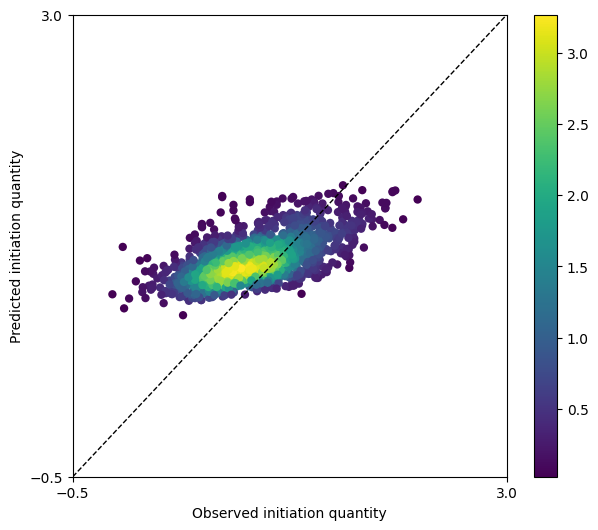

In [34]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
ax = sns.scatterplot(
    data=enh.iloc[:, :2],
    x="expt",
    y="clipnet",
    c=gaussian_kde(enh.transpose())(enh.transpose()),
    cmap="viridis",
    alpha=1,
    linewidth=0,
)
fig.colorbar(ax.collections[0], ax=ax, orientation="vertical")
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)
ax.set_xticks([-0.5, 3])
#ax.set_xticklabels(["", ""])
ax.set_yticks([-0.5, 3])
#ax.set_yticklabels(["", ""])
ax.set_ylabel("Predicted initiation quantity")
ax.set_xlabel("Observed initiation quantity")
ax.plot([-0.5, 3], [-0.5, 3], color="black", linestyle="--", linewidth=1)
plt.savefig("img/log_quantity_enh.pdf")

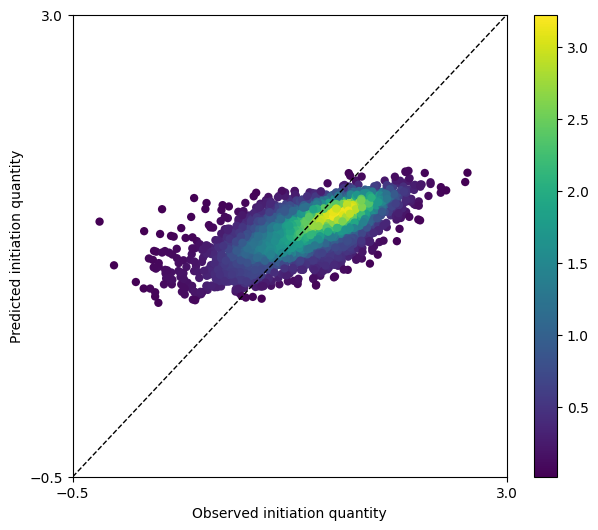

In [33]:
# Plot predicted vs observed log quantities

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
ax = sns.scatterplot(
    data=prom,
    x="expt",
    y="clipnet",
    c=gaussian_kde(prom.transpose())(prom.transpose()),
    cmap="viridis",
    alpha=1,
    linewidth=0,
)
fig.colorbar(ax.collections[0], ax=ax, orientation="vertical")
ax.set_xlim(-0.5, 3)
ax.set_ylim(-0.5, 3)
ax.set_xticks([-0.5, 3])
#ax.set_xticklabels(["", ""])
ax.set_yticks([-0.5, 3])
#ax.set_yticklabels(["", ""])
ax.set_ylabel("Predicted initiation quantity")
ax.set_xlabel("Observed initiation quantity")
ax.plot([-0.5, 3], [-0.5, 3], color="black", linestyle="--", linewidth=1)
plt.savefig("img/log_quantity_prom.pdf")

PearsonRResult(statistic=0.7399901117824242, pvalue=0.0)


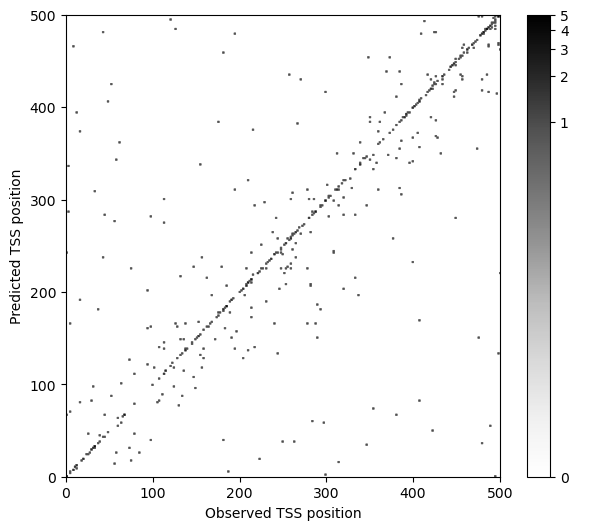

In [130]:
# Plot predicted vs observed TSS position (colored by log density)

norm = ImageNormalize(stretch=LogStretch())

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1, projection="scatter_density")
log_density = ax.scatter_density(
    x=tss_["expt"],
    y=tss_["clipnet"],
    cmap="Greys",
    norm=norm,
)
fig.colorbar(log_density)
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)
ax.set_ylabel("Predicted TSS position")
ax.set_xlabel("Observed TSS position")
#plt.savefig("img/tss.pdf")

print(pearsonr(tss.expt, tss.clipnet))